In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.interpolate
from math import ceil
from scipy import linalg
print("Libraries imported")

def binom(c, n, k):
    return  k * c**n * (1-c)**(5-n)

def binom2(c, n, k):
    return  k * c**n * (1-c)**(2-n)

def lowess_ag(x, y, f=0.5, iter=10):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

# ENTER ROOT DIRECTORY HERE 
root_dir = "d:/CAM/PhD_Year2/FSSE/postproc"
if len(root_dir) == 0:
    root_dir = input("Work directory path: ")

Libraries imported


### DGEBA-P4A

In [9]:
from post_process import PostProcess

pp = PostProcess("DGEBA-P4A", [130, 65], "MD")
pp.chdir = root_dir + "/data/DGEBA_P4A/outfiles"
pp.n_runs = 20
pp.funcs = [2, 4]
pp.set_summary_path = pp.chdir + "/monomer_keys.txt"
pp.run_folder_rootname = "run"

Tsim = []
for i in range(pp.n_runs):
    if(i < 10):
        Tsim.append(pp.simulation_time(pp.chdir+'/run_0'+str(i)+'.out')/1e6)
    else:
        Tsim.append(pp.simulation_time(pp.chdir+'/run_'+str(i)+'.out')/1e6)
print("Average simulation time:",np.mean(Tsim),'ns')

c_a, t_a = pp.conversion_properties()
#plt.plot(t_a,np.array(c_a)/280, label='P4A')
#plt.xlabel("time (ns)")
#plt.ylabel("conversion")
#plt.legend()
print("Average max conversion:",c_a[-1]/280)

Average simulation time: 1.1570799999999997 ns
Average max conversion: 0.7265306122448979


In [10]:
distr0 = pp.degree_distribution_properties(pp.funcs, pp.n_runs, plot=False)
distr0 = np.array(distr0)
max_conv = distr0[0][1][-1]
min_conv = distr0[0][1][0]
distr = np.array(distr0[1])
c = distr0[0][0]
c4 = np.array(c)
c2 = np.arange(c[0], 1 + c[1]-c[0], c[1]-c[0])

appear = []
for i in range(len(distr)):
    appended = False
    for j in range(1, len(distr[i])):
        if(distr[i][0] > 0.01 and appended == False ):
            appear.append(0)
            appended = True
            break
        if(distr[i][j] > 0.01 and distr[i][j-1] <= 0.01 and appended == False):
            appear.append(j)
            appended = True
            break
            
disappear = []
for i in range(len(distr)):
    appended = False
    for j in range(1, len(distr[i])):
        if(distr[i][j] < 0.01 and distr[i][j-1] >= 0.01):
            disappear.append(j)
            appended = True
            break
    if(not appended):
        disappear.append(len(distr[0]))

smooth_distr_4 = []
for i in range(len(distr)):
    if(i<8):
        yest = lowess_ag(c, distr[i], f=0.1, iter=10)
        smooth_distr_4.append(np.array(yest))
    else:
        yest = lowess_ag(c[appear[i]:], distr[i][appear[i]:], f=0.1, iter=10)
        smooth_distr_4.append(np.concatenate((np.zeros(appear[i]),np.array(yest)),axis=None))
smooth_distr_4 = np.array(smooth_distr_4)

reacted_fraction = []
for i in range(4):
    reacted_fraction.append(np.sum(distr[3:i+4], axis=0))
    
smooth_reacted_fraction = []
i = 0
for y in reacted_fraction:
    yest = lowess_ag(c, y, f=0.1, iter=10)
    smooth_reacted_fraction.append(np.array(yest))
    i += 1
    
smooth_reacted_fraction_gradient_4 = []
for i in range(len(smooth_reacted_fraction)):
    grad = np.gradient(smooth_reacted_fraction[i])
    smooth_reacted_fraction_gradient_4.append(lowess_ag(c, grad, f=0.3, iter=10))

S0 = 4
norm_4 = smooth_distr_4[3]/np.gradient(-smooth_distr_4[3], c)*S0
norm2_4 = norm_4[:87]
norm2_4 = np.append(norm2_4, 0)
c2_4 = c[:87]
c2_4 = np.append(c2_4, 1)
smooth_norm2_4 = lowess_ag(c2_4, norm2_4, 0.3, 10)
smooth_norm2_interp_4 = np.interp(c, c2_4, smooth_norm2_4)

#plt.plot(c,norm_4,label='raw_norm')
#plt.plot(c,(1-c),label='ideal')
#plt.grid()
#plt.plot(c, smooth_norm2_interp_4, ls='--',color='xkcd:pink',label='fit_norm')
#plt.legend()
#plt.title("FSSE Normalising Factor")

d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
D:\CAM\PhD_Year2\FSSE\postproc\post_process.py:609: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  distr_all = np.array(distr_all)


### DGEBA-P5A

In [11]:
from post_process import PostProcess

pp = PostProcess("DGEBA_P5A", [140, 56], "MD")
pp.chdir = root_dir + "/data/DGEBA_P5A/outfiles"
pp.n_runs = 19
pp.funcs = [2,5]
pp.set_summary_path = pp.chdir + "/monomer_keys.txt"
pp.run_folder_rootname = "run"

Tsim = []
for i in range(pp.n_runs):
    if(i < 10):
        Tsim.append(pp.simulation_time(pp.chdir+'/run_0'+str(i)+'.out')/1e6)
    else:
        Tsim.append(pp.simulation_time(pp.chdir+'/run_'+str(i)+'.out')/1e6)
print("Average simulation time:",np.mean(Tsim),'ns')

c_b, t_b = pp.conversion_properties()
#plt.plot(t_b,np.array(c_b)/280, label='P5A')
#plt.xlabel("time (ns)")
#plt.ylabel("conversion")
#plt.legend()
print("Average max conversion:",c_b[-1]/280)

Average simulation time: 0.8770526315789473 ns
Average max conversion: 0.7408163265306122


In [12]:
distr0 = pp.degree_distribution_properties(pp.funcs, pp.n_runs, plot=False)
distr0 = np.array(distr0)
max_conv = distr0[0][1][-1]
min_conv = distr0[0][1][0]

distr = np.array(distr0[1])
c = distr0[0][0]
c5 = np.array(c)
c2 = np.arange(c[0], 1 + c[1]-c[0], c[1]-c[0])



appear = []
for i in range(len(distr)):
    appended = False
    for j in range(1, len(distr[i])):
        if(distr[i][0] > 0.01 and appended == False ):
            appear.append(0)
            appended = True
            break
        if(distr[i][j] > 0.01 and distr[i][j-1] <= 0.01 and appended == False):
            appear.append(j)
            appended = True
            break
            
disappear = []
for i in range(len(distr)):
    appended = False
    for j in range(1, len(distr[i])):
        if(distr[i][j] < 0.01 and distr[i][j-1] >= 0.01):
            disappear.append(j)
            appended = True
            break
    if(not appended):
        disappear.append(len(distr[0]))

smooth_distr_5 = []
for i in range(len(distr)):
    if(i<8):
        yest = lowess_ag(c, distr[i], f=0.1, iter=10)
        smooth_distr_5.append(np.array(yest))
    else:
        yest = lowess_ag(c[appear[i]:], distr[i][appear[i]:], f=0.1, iter=10)
        smooth_distr_5.append(np.concatenate((np.zeros(appear[i]),np.array(yest)),axis=None))
smooth_distr_5 = np.array(smooth_distr_5)
    
reacted_fraction = []
for i in range(5):
    reacted_fraction.append(np.sum(distr[3:i+4], axis=0))
smooth_reacted_fraction = []
for i in range(len(reacted_fraction)):
    if(i < 4):
        yest = lowess_ag(c, reacted_fraction[i], f=0.1, iter=10)
        smooth_reacted_fraction.append(np.array(yest))
    else:
        test_reacted_fraction = reacted_fraction[i][appear[i+3]:]
        yest = lowess_ag(c[appear[i+3]:], reacted_fraction[i][appear[i+3]:], f=0.1, iter=10)
        smooth_reacted_fraction.append(np.concatenate((np.ones(appear[i+3]),np.array(yest)),axis=None))
    
smooth_reacted_fraction_gradient_5 = []
for i in range(len(smooth_reacted_fraction)):
    grad = np.gradient(smooth_reacted_fraction[i])
    smooth_reacted_fraction_gradient_5.append(lowess_ag(c, grad, f=0.3, iter=10))
    
S0 = 5
norm_5 = smooth_distr_5[3]/np.gradient(-smooth_distr_5[3], c)*S0
norm2_5 = norm_5[:87]
norm2_5 = np.append(norm2_5, 0)
c2_5 = c[:87]
c2_5 = np.append(c2_5, 1)
smooth_norm2_5 = lowess_ag(c2_5, norm2_5, 0.95, 10)
smooth_norm2_interp_5 = np.interp(c, c2_5, smooth_norm2_5)

#plt.plot(c,norm_5,label='raw_norm')
#plt.plot(c,(1-c),label='ideal')
#plt.grid()
#plt.plot(c, smooth_norm2_interp_5, ls='--',color='xkcd:pink',label='fit_norm')
#plt.legend()

### DGEBA-P6A

In [13]:
from post_process import PostProcess

pp = PostProcess("DGEBA_P6A", [150, 50], "MD")
pp.chdir = root_dir + "/data/DGEBA_P6A/outfiles"
pp.n_runs = 17
pp.funcs = [2,6]
pp.set_summary_path = pp.chdir + "/monomer_keys.txt"
pp.run_folder_rootname = "run"

Tsim = []
for i in range(pp.n_runs):
    if(i < 10):
        Tsim.append(pp.simulation_time(pp.chdir+'/run_0'+str(i)+'.out')/1e6)
    else:
        Tsim.append(pp.simulation_time(pp.chdir+'/run_'+str(i)+'.out')/1e6)
print("Average simulation time:",np.mean(Tsim),'ns')

c_c, t_c = pp.conversion_properties()
#plt.plot(t_c,np.array(c_c)/300, label='P6A')
#plt.xlabel("time (ns)")
#plt.ylabel("conversion")
#plt.legend()
print("Average max conversion:",c_c[-1]/300)

Average simulation time: 0.6862117647058823 ns
Average max conversion: 0.6816666666666666


In [14]:
distr0 = pp.degree_distribution_properties(pp.funcs, pp.n_runs, plot=False)
distr0 = np.array(distr0)
max_conv = distr0[0][1][-1]
min_conv = distr0[0][1][0]

distr = np.array(distr0[1])
c = distr0[0][0]
c6 = np.array(c)
c2 = np.arange(c[0], 1 + c[1]-c[0], c[1]-c[0])


appear = []
for i in range(len(distr)):
    appended = False
    for j in range(1, len(distr[i])):
        if(distr[i][0] > 0.01 and appended == False ):
            appear.append(0)
            appended = True
            break
        if(distr[i][j] > 0.01 and distr[i][j-1] <= 0.01 and appended == False):
            appear.append(j)
            appended = True
            break
            
disappear = []
for i in range(len(distr)):
    appended = False
    for j in range(1, len(distr[i])):
        if(distr[i][j] < 0.01 and distr[i][j-1] >= 0.01):
            disappear.append(j)
            appended = True
            break
    if(not appended):
        disappear.append(len(distr[0]))

smooth_distr_6 = []
for i in range(len(distr)):
    if(i == 3):
        yest = lowess_ag(c[appear[i]:disappear[i]], distr[i][appear[i]:disappear[i]], f=0.015, iter=10)
        yest_1 = np.concatenate((np.zeros(appear[i]),np.array(yest)),axis=None)
        yest_2 = np.concatenate((yest_1, np.zeros(len(distr[0])-disappear[i])),axis=None)
        yest = yest_2
        smooth_distr_6.append(yest_2)
    elif(i < 9):
        yest = lowess_ag(c[appear[i]:], distr[i][appear[i]:], f=0.2, iter=10)
        smooth_distr_6.append(np.concatenate((np.zeros(appear[i]),np.array(yest)),axis=None))
    else:
        yest = lowess_ag(c[appear[i]:], distr[i][appear[i]:], f=0.3, iter=10)
        smooth_distr_6.append(np.concatenate((np.zeros(appear[i]),np.array(yest)),axis=None))
smooth_distr_6 = np.array(smooth_distr_6)
   
reacted_fraction = []
for i in range(6):
    reacted_fraction.append(np.sum(distr[3:i+4], axis=0))
smooth_reacted_fraction = []
for i in range(len(reacted_fraction)):
        test_reacted_fraction = reacted_fraction[i][appear[i+3]:]
        yest = lowess_ag(c[appear[i+3]:], reacted_fraction[i][appear[i+3]:], f=0.3, iter=10)
        smooth_reacted_fraction.append(np.concatenate((np.ones(appear[i+3]),np.array(yest)),axis=None))
    
smooth_reacted_fraction_gradient_6 = []
for i in range(len(smooth_reacted_fraction)):
    grad = np.gradient(smooth_reacted_fraction[i])
    smooth_reacted_fraction_gradient_6.append(lowess_ag(c, grad, f=0.3, iter=10))

S0 = 6
norm_6 = smooth_distr_6[3]/np.gradient(-smooth_distr_6[3], c)*S0

#plt.plot(c,norm_6,label='raw_norm')
#plt.plot(c,(1-c),label='ideal')
#plt.grid()

norm2_6 = norm_6[:100]
norm2_6 = np.append(norm2_6, 0)
c2_ = c[:100]
c2_ = np.append(c2_, 1)

smooth_norm2_6 = lowess_ag(c2_, norm2_6, 0.8, 10)
smooth_norm2_interp_6 = np.interp(c, c2_, smooth_norm2_6)

#plt.plot(c, smooth_norm2_interp_6, ls='--',color='xkcd:pink',label='fit_norm')
#plt.legend()
#plt.ylim([0,1.5])


yest = lowess_ag(c, distr[3], f=0.6, iter=10)
smooth_distr_6[3] = np.array(yest)

d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


conversion-time

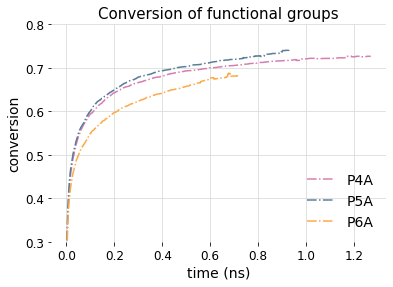

In [36]:
plt.plot(t_a, np.array(c_a)/280, label='P4A', color="#d57eb0", ls="-.")
plt.plot(t_b, np.array(c_b)/280, label='P5A', color="#5a7d9a", ls="-.")
plt.plot(t_c, np.array(c_c)/300, label='P6A', color="#fdaa48", ls="-.")
plt.legend(frameon=False, fontsize=14)
plt.xlabel("time (ns)", fontsize=14)
plt.ylim([0.3, 0.8])
plt.ylabel("conversion", fontsize=14)
plt.tick_params(axis='both', labelsize=12)
i = 0
for spine in plt.gca().spines.values():
    spine.set_visible(False) 
    i += 1
plt.grid(color="xkcd:light grey")    
plt.title("Conversion of functional groups", fontsize=15)
plt.savefig(root_dir + "/data/conversion.png", bbox_inches='tight')

normalising factors

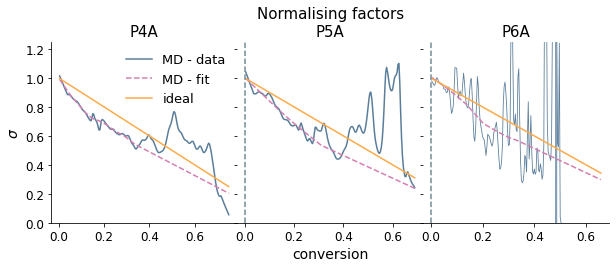

In [37]:
fig, axis = plt.subplots(1,3, sharey="row", gridspec_kw={'wspace': 0., 'hspace': 0.}, figsize=(10,3.33))

axis[0].plot(c4,norm_4,label='MD - data', color="#5a7d9a")
#axis[0].grid()
axis[0].plot(c4, smooth_norm2_interp_4, ls='--',color='#d57eb0',label='MD - fit')
axis[0].plot(c4,(1-c4),label='ideal', color="#fdaa48")

axis[1].plot(c5,norm_5,label='MD - data', color="#5a7d9a")
#axis[1].grid()
axis[1].plot(c5, smooth_norm2_interp_5, ls='--',color='#d57eb0',label='MD - fit')
axis[1].plot(c5,(1-c5),label='ideal', color="#fdaa48")

axis[2].plot(c6,norm_6,label='MD - data', color="#5a7d9a", lw=0.8)
#axis[2].grid()
axis[2].plot(c6, smooth_norm2_interp_6, ls='--',color='#d57eb0',label='MD - fit')
axis[2].plot(c6,(1-c6),label='ideal', color="#fdaa48")
axis[2].set_ylim([0,1.25])

axis[0].set_ylabel(r"$\sigma$", fontsize=14)
axis[1].set_xlabel("conversion", fontsize=14)
axis[0].set_title("P4A", fontsize=15)
axis[1].set_title("Normalising factors\nP5A", fontsize=15)
axis[2].set_title("P6A", fontsize=15)
axis[0].legend(frameon=False, fontsize=13)
for i in range(3):
    if(i > 0):
        axis[i].axvline(0, ls='--', color=('xkcd:bluish grey'))
    axis[i].spines["top"].set_visible(False)
    axis[i].spines["right"].set_visible(False)
    axis[i].tick_params(axis='both', labelsize=12)
    if(i > 0):
        axis[i].spines["left"].set_visible(False)
        
plt.savefig(root_dir + "/data/norm_factor.png", bbox_inches='tight')

fsse factors

d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero enco

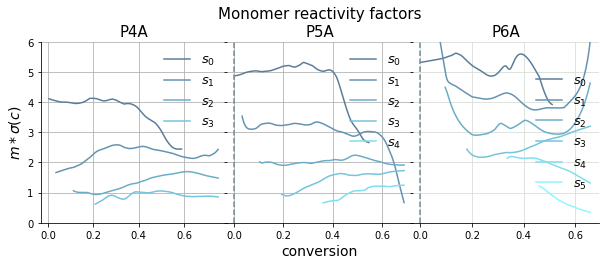

In [38]:
fig, axis = plt.subplots(1, 3, sharey="row", gridspec_kw={'wspace': 0., 'hspace': 0.}, figsize=(10,3.33))
colors = ["#5b7c99", "#6393b1", "#6bacc7", "#74c4dc", "#80deee", "#8ff7ff"]
labels = [r"$s_0$", r"$s_1$", r"$s_2$", r"$s_3$", r"$s_4$", r"$s_5$"]
for i in range(4):
    if(i == 0):
        axis[0].plot(c4[appear[i+4]:153], 
                     (-260*smooth_reacted_fraction_gradient_4[i]/smooth_distr_4[i+3]*smooth_norm2_interp_4)[appear[i+4]:153],
                     label=labels[i], color=colors[i])
    else:
        axis[0].plot(c4[appear[i+4]:],
                     (-260*smooth_reacted_fraction_gradient_4[i]/smooth_distr_4[i+3]*smooth_norm2_interp_4)[appear[i+4]:],
                     label=labels[i], color=colors[i])   
axis[0].grid()   
axis[0].legend(frameon=False, fontsize=13)
axis[0].set_ylabel(r"$m*\sigma (c)$", fontsize=14)
axis[0].set_title("P4A", fontsize=15)

for i in range(5):
    if(i == 0):
        axis[1].plot(c5[appear[i+4]:153], 
                     (-280*smooth_reacted_fraction_gradient_5[i]/smooth_distr_5[i+3]*smooth_norm2_interp_5)[appear[i+4]:153],
                     label=labels[i], color=colors[i])
    else:
        axis[1].plot(c5[appear[i+4]:], 
                     (-280*smooth_reacted_fraction_gradient_5[i]/smooth_distr_5[i+3]*smooth_norm2_interp_5)[appear[i+4]:],
                     label=labels[i], color=colors[i])   
axis[1].grid()   
axis[1].legend(frameon=False, fontsize=13)
axis[1].set_xlabel("conversion", fontsize=14)
axis[1].set_title("Monomer reactivity factors\nP5A", fontsize=15)

for i in range(6):
    if(i == 0):
        axis[2].plot(c6[appear[i+4]:153], 
                     (-300*smooth_reacted_fraction_gradient_6[i]/smooth_distr_6[i+3]*smooth_norm2_interp_6)[appear[i+4]:153],
                     label=labels[i], color=colors[i])
    else:
        axis[2].plot(c6[appear[i+4]:], 
                     (-300*smooth_reacted_fraction_gradient_6[i]/smooth_distr_6[i+3]*smooth_norm2_interp_6)[appear[i+4]:],
                     label=labels[i], color=colors[i])   
axis[2].grid(color="xkcd:light grey")   
axis[2].legend(frameon=False, fontsize=13, loc='right') 
axis[2].set_title("P6A", fontsize=15)
axis[2].set_ylim([0,6])

for i in range(3):
    if(i > 0):
        axis[i].axvline(0, ls='--', color=('xkcd:bluish grey'))
    axis[i].spines["top"].set_visible(False)
    axis[i].spines["right"].set_visible(False)
    if(i > 0):
        axis[i].spines["left"].set_visible(False)

plt.savefig(root_dir + "/data/fsse_factors.png", bbox_inches='tight')

polydispersity index

In [19]:
from post_process import PostProcess

pp = PostProcess("DGEBA_P5A", [140, 56], "MD")
pp.chdir = root_dir + "/data/DGEBA_P5A/outfiles"
pp.n_runs = 19
pp.set_summary_path = pp.chdir + "/monomer_keys.txt"
pp.run_folder_rootname = "run"
num_all, weight_all, mean_all, z_all, visc_all, averages_5 = pp.size_distribution_properties()


...................

d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
D:\CAM\PhD_Year2\FSSE\postproc\post_process.py:393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num_all = np.array(num_all)
D:\CAM\PhD_Year2\FSSE\postproc\post_process.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

In [20]:
from post_process import PostProcess

pp = PostProcess("DGEBA_P5A", [140, 56], "graph")
pp.chdir = root_dir + "/data/DGEBA_P5A/graph_outfiles/"
pp.n_runs = 100
pp.run_folder_rootname = "ideal_run"
num_all, weight_all, mean_all, z_all, visc_all, averages_5gi = pp.size_distribution_properties()

....................................................................................................

In [21]:
from post_process import PostProcess

pp = PostProcess("DGEBA_P5A", [140, 56], "graph")
pp.chdir = root_dir + "/data/DGEBA_P5A/graph_outfiles/"
pp.n_runs = 100
pp.run_folder_rootname = "run"
num_all, weight_all, mean_all, z_all, visc_all, averages_5g = pp.size_distribution_properties()

....................................................................................................

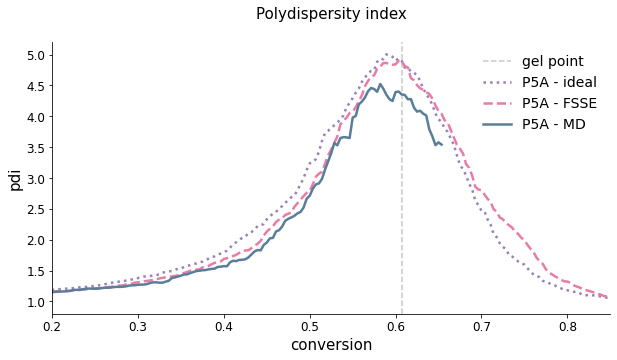

In [39]:
fig, axis = plt.subplots(1, 1, gridspec_kw={'wspace': 0., 'hspace': 0.}, figsize=(10,5))


N = 280
N2 = 560
N8 = 2240

#pdi_6g = np.array(averages_6g[1])/np.array(averages_6g[2])
#pdi_6gi = np.array(averages_6gi[1])/np.array(averages_6gi[2])
#pdi_4g = np.array(averages_4g[1])/np.array(averages_4g[2])
pdi_5 = np.array(averages_5[1])/np.array(averages_5[2])
pdi_5g = np.array(averages_5g[1])/np.array(averages_5g[2])
pdi_5gi = np.array(averages_5gi[1])/np.array(averages_5gi[2])
#pdi_5gix8 = np.array(averages_5gix8[1])/np.array(averages_5gix8[2])

axis.axvline(0.607, ls='--',color='xkcd:silver',label='gel point')
#print(np.arange(1./N, (len(pdi_6g)+1.)/N, 1./N)[166])
#axis.plot(np.arange(1./N, (len(pdi_6g)+1.)/N, 1./N), pdi_6g, color='tab:orange', ls='--',label='p6a_fsse')
#axis.plot(np.arange(1./N, (len(pdi_6gi)+1.)/N, 1./N), pdi_6gi, color='tab:orange', ls=':',label='p6a_ideal')
#axis.plot(np.arange(1./N, (len(pdi_4g)+1.)/N, 1./N), pdi_4g, color='tab:green', ls='--',label='p4a_fsse')
#axis.plot(np.arange(1./N8, (len(pdi_5gix8)+1.)/N8, 1./N8), pdi_5gix8, color='tab:purple', ls=':',label='p5a_ideal_x8')
axis.plot(np.arange(1./N, (len(pdi_5gi)+1.)/N, 1./N), pdi_5gi, color="#9881b8", ls=':',label='P5A - ideal', lw=2.5)
axis.plot(np.arange(1./N, (len(pdi_5g)+1.)/N, 1./N), pdi_5g, color='#e77da6', ls='--',label='P5A - FSSE', lw=2.5)
axis.plot(np.arange(1./N, (len(pdi_5)+1.)/N, 1./N)[:-10], pdi_5[:-10], color="#5a7d9a",label='P5A - MD', lw=2.5)

axis.set_ylabel("pdi", fontsize=15)
axis.set_xlabel("conversion", fontsize=15)
axis.legend(frameon=False, fontsize=14)
axis.set_title("Polydispersity index\n", fontsize=15)

axis.spines["top"].set_visible(False)
axis.spines["right"].set_visible(False)
axis.set_xlim([0.2,0.85])
axis.tick_params(axis='both', labelsize=12)

plt.savefig(root_dir + "/data/pdi_p5a.png", bbox_inches='tight')

degree distributions

In [23]:
from post_process import PostProcess

pp = PostProcess("DGEBA_P5A", [140, 56], "MD")
pp.chdir = root_dir + "/data/DGEBA_P5A/outfiles"
pp.n_runs = 19
pp.funcs = [2,5]
pp.set_summary_path = pp.chdir + "/monomer_keys.txt"
pp.run_folder_rootname = "run"
distr0 = pp.degree_distribution_properties(pp.funcs, pp.n_runs, plot=False)
distr0 = np.array(distr0)
distr = np.array(distr0[1])
c = distr0[0][0]

pp = PostProcess("DGEBA_P5A", [140, 56], "graph")
pp.chdir = root_dir + "/data/DGEBA_P5A/graph_outfiles/"
pp.n_runs = 100
pp.run_folder_rootname = "ideal_run"
distr0 = pp.degree_distribution_properties(pp.funcs, pp.n_runs, plot=False)
distr0 = np.array(distr0)
distr_gl = np.array(distr0[1])
c_gl = distr0[0][0]

pp = PostProcess("DGEBA_P5A", [140, 56], "graph")
pp.chdir = root_dir + "/data/DGEBA_P5A/graph_outfiles/"
pp.n_runs = 100
pp.run_folder_rootname = "run"
distr0 = pp.degree_distribution_properties(pp.funcs, pp.n_runs, plot=False)
distr0 = np.array(distr0)
distr_g = np.array(distr0[1])
c_g = distr0[0][0]

def binom(c, n, k):
    return  k * c**n * (1-c)**(5-n)

d:\cam\phd_year2\fsse\postproc\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
D:\CAM\PhD_Year2\FSSE\postproc\post_process.py:609: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  distr_all = np.array(distr_all)


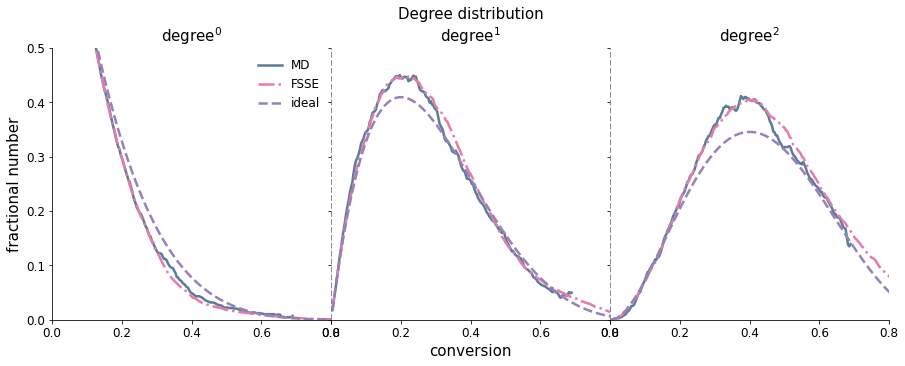

In [47]:
fig, axis = plt.subplots(1, 3, sharey="row", gridspec_kw={'wspace': 0., 'hspace': 0.}, figsize=(15,5))

for i in range(3):
    axis[i].plot(c, distr[i+3], label='MD', lw=2.5, color="#5a7d9a")
    axis[i].plot(c_g, distr_g[i+3], label='FSSE', ls='-.', lw=2.5, color='#e77da6') #(78/255, 179/255, 211/255)
    #axis[i].plot(c_gl, distr_gl[i+3], label='graph (linear)', ls='--')
    axis[i].plot(c_gl, binom(c_gl,  i, scipy.special.comb(5, i)), ls='--', label='ideal', lw=2.5, color="#9881b8")
    #axis[i].set_title("degree "+str(i), fontsize=15)
    axis[i].set_ylim([0,0.5])
axis[0].legend(frameon=False, fontsize=12)
axis[1].set_xlabel("conversion", fontsize=15)
axis[0].set_ylabel("fractional number", fontsize=15)

for i in range(3):
    if(i > 0):
        axis[i].axvline(0, ls='--', color=('xkcd:bluish grey'))
        axis[i].axvline(0, ls='--', color=('xkcd:bluish grey'))
    axis[i].spines["top"].set_visible(False)
    axis[i].spines["right"].set_visible(False)
    axis[i].spines["left"].set_visible(False)
    axis[i].set_xlim([0,0.8])
    axis[i].tick_params(axis='both', labelsize=12)
axis[0].spines["left"].set_visible(True)
axis[0].set_title(r"degree$^0$", fontsize=15)
axis[1].set_title("Degree distribution\n" + r"degree$^1$", fontsize=15)
axis[2].set_title(r"degree$^2$", fontsize=15)

plt.savefig(root_dir + "/data/degree_distribution_P5A_1-3.png", bbox_inches='tight')

gel point

In [29]:
from post_process_ import PostProcess

topo_data = {}

loads = [130,65]
pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P4A/graph/ideal/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p4a_ideal"] = pp.topology_data

pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P4A/graph/fsse/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p4a_fsse"] = pp.topology_data

pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P4A/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p4a_md"] = pp.topology_data

loads = [140,56]
pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P5A/graph/ideal/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p5a_ideal"] = pp.topology_data

pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P5A/graph/fsse/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p5a_fsse"] = pp.topology_data

pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P5A/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p5a_md"] = pp.topology_data

loads = [150,50]
pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P6A/graph/ideal/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p6a_ideal"] = pp.topology_data

pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P6A/graph/fsse/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p6a_fsse"] = pp.topology_data

pp = PostProcess(loads, 'file', reactions_folder_path=root_dir + '/data/gel-point/DGEBA_P6A/', 
                 reaction_file_root='run_')
pp.average_sizes(reduced=True)
topo_data["p6a_md"] = pp.topology_data

.................
....................
....................
....................
....................
...................
....................
....................
..................


D:\CAM\PhD_Year2\FSSE\postproc\post_process_.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.number = np.array(number_ave_data)
D:\CAM\PhD_Year2\FSSE\postproc\post_process_.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.weight = np.array(weight_ave_data)


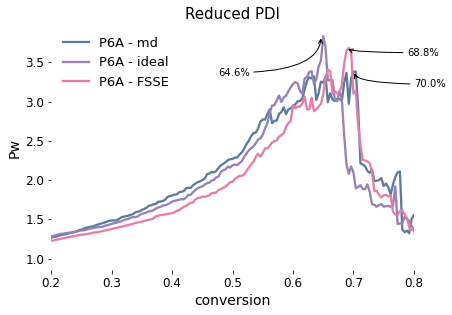

In [41]:
import matplotlib.pyplot as plt
import numpy as np

var = "dispersion_index"
n1, n2, n3 = 260, 280, 300
c1 = np.linspace(1/n1, 1, n1)
c2 = np.linspace(1/n2, 1, n2)
c3 = np.linspace(1/n3, 1, n3)

d1 = topo_data["p4a_md"][var]
d2 = topo_data["p4a_ideal"][var]
d3 = topo_data["p4a_fsse"][var]

x1, y1 = np.argmax(d1)/float(n1), np.max(d1)
x2, y2 =np.argmax(d2)/float(n1), np.max(d2)
x3, y3 = np.argmax(d3)/float(n1), np.max(d3)

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.plot(c1[:len(d1)], d1, lw=2.3, color='#5a7d9a', label='P6A - md')
ax.plot(c1[:len(d2)], d2, lw=2.3, color='#9881b8', label='P6A - ideal')
ax.plot(c1[:len(d3)], d3, lw=2.3, color='#e77da6', label='P6A - FSSE')

ax.annotate(f'{np.round(x1*100,1)}%', xy=(x1, y1), xytext=(x1+0.1, y1-0.2),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(f'{np.round(x2*100,1)}%', xy=(x2, y2), xytext=(x2-0.17, y2-.5),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(f'{np.round(x3*100,1)}%', xy=(x3, y3), xytext=(x3+0.1, y3-0.1),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))

ax.set_xlabel("conversion", fontsize=14)
ax.set_ylabel("Pw", fontsize=14)
ax.legend(frameon=False, loc="upper left", fontsize=13)
ax.set_title("Reduced PDI", fontsize=15)
ax.set_xlim([0.2, 0.8])
ax.tick_params(axis='both', labelsize=12)

fig.savefig(root_dir + "/data/gel_point_p4a.png")

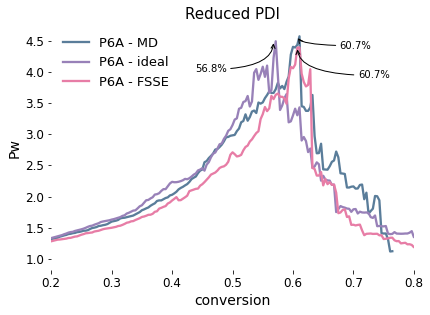

In [42]:
d1 = topo_data["p5a_md"][var]
d2 = topo_data["p5a_ideal"][var]
d3 = topo_data["p5a_fsse"][var]

x1, y1 = np.argmax(d1)/float(n2), np.max(d1)
x2, y2 =np.argmax(d2)/float(n2), np.max(d2)
x3, y3 = np.argmax(d3)/float(n2), np.max(d3)

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.plot(c2[:len(d1)], d1, lw=2.3, color='#5a7d9a', label='P6A - MD')
ax.plot(c2[:len(d2)], d2, lw=2.3, color='#9881b8', label='P6A - ideal')
ax.plot(c2[:len(d3)], d3, lw=2.3, color='#e77da6', label='P6A - FSSE')

ax.annotate(f'{np.round(x1*100,1)}%', xy=(x1, y1), xytext=(x1+0.07, y1-0.2),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(f'{np.round(x2*100,1)}%', xy=(x2, y2), xytext=(x2-0.13, y2-.5),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(f'{np.round(x3*100,1)}%', xy=(x3, y3), xytext=(x3+0.1, y3-0.5),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))

ax.set_xlabel("conversion", fontsize=14)
ax.set_ylabel("Pw", fontsize=14)
ax.legend(frameon=False, loc="upper left", fontsize=13)
ax.set_title("Reduced PDI", fontsize=15)
ax.set_xlim([0.2, 0.8])
ax.tick_params(axis='both', labelsize=12)

fig.savefig(root_dir + "/data/gel_point_p5a.png")

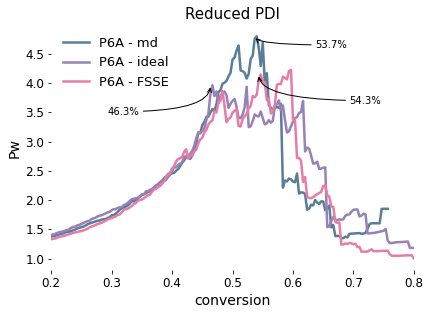

In [43]:
d1 = topo_data["p6a_md"][var]
d2 = topo_data["p6a_ideal"][var]
d3 = topo_data["p6a_fsse"][var]

x1, y1 = np.argmax(d1)/float(n3), np.max(d1)
x2, y2 = np.argmax(d2)/float(n3), np.max(d2)
x3, y3 = 163./n3, 4.15

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.plot(c3[:len(d1)], d1, lw=2.5, color='#5a7d9a', label='P6A - md')
ax.plot(c3[:len(d2)], d2, lw=2.5, color='#9881b8', label='P6A - ideal')
ax.plot(c3[:len(d3)], d3, lw=2.5, color='#e77da6', label='P6A - FSSE')

ax.annotate(f'{np.round(x1*100,1)}%', xy=(x1, y1), xytext=(x1+0.1, y1-0.2),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(f'{np.round(x2*100,1)}%', xy=(x2, y2), xytext=(x2-0.17, y2-.5),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate(f'{np.round(x3*100,1)}%', xy=(x3, y3), xytext=(x3+0.15, y3-0.5),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle3,angleA=0,angleB=-90"))

ax.set_xlabel("conversion", fontsize=14)
ax.set_ylabel("Pw", fontsize=14)
ax.legend(frameon=False, loc="upper left", fontsize=13)
ax.set_title("Reduced PDI", fontsize=15)
ax.set_xlim([0.2, 0.8])
ax.tick_params(axis='both', labelsize=12)

fig.savefig(root_dir + "/data/gel_point_p6a.png")